In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Load the dataset in a Pandas dataframe
df = pd.read_csv('datacreditos.csv', delimiter=';')

# Select the features and target variable
features = ['Loan_Type', 'Gender', 'Degree', 'Citizenship', 'Age', 'Income', 'Credit_Score', 'Loan_Length', 'Signers']
target = 'Default'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Handle missing values and scale numerical features
numerical_features = ['Age', 'Income', 'Credit_Score', 'Loan_Length']
categorical_features = ['Loan_Type', 'Gender', 'Degree', 'Citizenship', 'Signers']

# Define the preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                        ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('encoder', OneHotEncoder(drop='first'))])

# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply RandomUndersampling
undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_preprocessed, y_train)

# Apply RandomOversampling
oversampler = RandomOverSampler()
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_preprocessed, y_train)

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Train the logistic regression models
lr = LogisticRegression()

# Original training set
lr.fit(X_train_preprocessed, y_train)
y_pred_orig = lr.predict_proba(X_test_preprocessed)[:, 1]
brier_orig = brier_score_loss(y_test, y_pred_orig)
auc_orig = roc_auc_score(y_test, y_pred_orig)

# RandomUndersampling
lr.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersampled = lr.predict_proba(X_test_preprocessed)[:, 1]
brier_undersampled = brier_score_loss(y_test, y_pred_undersampled)
auc_undersampled = roc_auc_score(y_test, y_pred_undersampled)

# RandomOversampling
lr.fit(X_train_oversampled, y_train_oversampled)
y_pred_oversampled = lr.predict_proba(X_test_preprocessed)[:, 1]
brier_oversampled = brier_score_loss(y_test, y_pred_oversampled)
auc_oversampled = roc_auc_score(y_test, y_pred_oversampled)

# SMOTE
lr.fit(X_train_smote, y_train_smote)
y_pred_smote = lr.predict_proba(X_test_preprocessed)[:, 1]
brier_smote = brier_score_loss(y_test, y_pred_smote)
auc_smote = roc_auc_score(y_test, y_pred_smote)

# Change the intercept (prior correction)
lr.intercept_ += 0.5

# Updated predictions after intercept change
y_pred_updated = lr.predict_proba(X_test_preprocessed)[:, 1]
brier_updated = brier_score_loss(y_test, y_pred_updated)
auc_updated = roc_auc_score(y_test, y_pred_updated)

# Print the Brier scores and ROC AUC scores
print("Original Brier Score: {:.4f}".format(brier_orig))
print("Original ROC AUC: {:.4f}".format(auc_orig))
print("Brier Score after RandomUndersampling: {:.4f}".format(brier_undersampled))
print("ROC AUC after RandomUndersampling: {:.4f}".format(auc_undersampled))
print("Brier Score after RandomOversampling: {:.4f}".format(brier_oversampled))
print("ROC AUC after RandomOversampling: {:.4f}".format(auc_oversampled))
print("Brier Score after SMOTE: {:.4f}".format(brier_smote))
print("ROC AUC after SMOTE: {:.4f}".format(auc_smote))
print("Brier Score after intercept change: {:.4f}".format(brier_updated))
print("ROC AUC after intercept change: {:.4f}".format(auc_updated))


Original Brier Score: 0.0540
Original ROC AUC: 0.7460
Brier Score after RandomUndersampling: 0.1873
ROC AUC after RandomUndersampling: 0.7506
Brier Score after RandomOversampling: 0.1895
ROC AUC after RandomOversampling: 0.7407
Brier Score after SMOTE: 0.1917
ROC AUC after SMOTE: 0.7406
Brier Score after intercept change: 0.2595
ROC AUC after intercept change: 0.7406


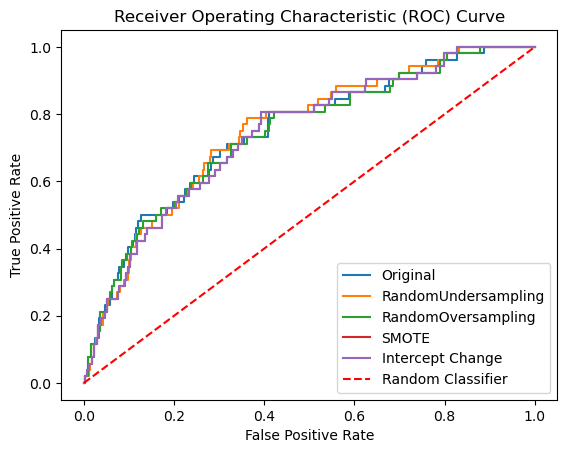

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate the false positive rate (FPR) and true positive rate (TPR) for each model
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_pred_orig)
fpr_undersampled, tpr_undersampled, _ = roc_curve(y_test, y_pred_undersampled)
fpr_oversampled, tpr_oversampled, _ = roc_curve(y_test, y_pred_oversampled)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_smote)
fpr_updated, tpr_updated, _ = roc_curve(y_test, y_pred_updated)

# Plot the ROC curve
plt.plot(fpr_orig, tpr_orig, label='Original')
plt.plot(fpr_undersampled, tpr_undersampled, label='RandomUndersampling')
plt.plot(fpr_oversampled, tpr_oversampled, label='RandomOversampling')
plt.plot(fpr_smote, tpr_smote, label='SMOTE')
plt.plot(fpr_updated, tpr_updated, label='Intercept Change')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Set plot legend
plt.legend()

# Show the plot
plt.show()
